<a href="https://colab.research.google.com/github/snghynn/ESAA-YB/blob/main/BOOK_%ED%8C%8C%EC%9D%B4%EC%8D%AC%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_pg147~174_0414_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter3. 평가
- 머신러닝의 단계: 데이터 가공/변환 -> 모델 학습/예측 -> 평가

[분류의 성능 평가 지표]
- 정확도(Accuracy)
- 오차행렬(Confusion Matrix)
- 정밀도(Precision)
- 재현율(Recall)
- F1 스코어
- ROC AUC



##1. 정확도(Accuracy)
- 정확도: 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표
- 정확도=(예측 결과가 동일한 데이터 건수)/(전체 예측 데이터 건수)
- 정확도는 직관적으로 모델 예측 성능을 나타내는 평가 지표
  - 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능 왜곡 가능

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
  #fit() 메서드는 아무것도 학습하지 않음.
  def fit(self, X, y=None):
    pass
  
  #predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함
  def predict(self,X):
    pred=np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
      if X['Sex'].iloc[i]==1:
        pred[i]=0
      else:
        pred[i]=1
    return pred

In [2]:
# 앞선 장에서 만들어놓은 전처리함수 
from sklearn.preprocessing import LabelEncoder
#Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

#머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

#레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

#앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [3]:
#생성된 MyDummyClassifier를 이용해 앞 장의 타이타닉 생존자 예측 수행
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df=pd.read_csv('train.csv')
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived', axis=1)
X_titanic_df=transform_features(X_titanic_df)
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

#위에서 생성한 Dummy Classifier를 이용해 학습/평가/예측 수행
myclf=MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions=myclf.predict(X_test)
print('Dummy Classifier의 정확도:, {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도:, 0.7877


이렇게 단순한 알고리즘으로 예측을 하더라도 데이터의 구성에 따라 정확도 결과는 꽤 높은 수치가 나올 수 있음. 

-> 정확도를 평가 지표로 사용할 때는 매우 신중해야 함.
  - 정확도는 불균형한(imbalanced) 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아님.


 ### [MNIST_불균형한 데이터의 정확도 지표 적용 시 발생할 수 있는 문제]

- 데이터 세트: 레이블 값이 0부터 9까지는 멀티 레이블 분류를 위한 것
- 7인 것을 True, 나머지 값을 모두 False로 변환(전체 데이터의 10%만 True, 나머지 90%는 False인 불균형한 데이터 세트)

>  
- 불균형한 데이터 세트에 모든 데이터를 False, 즉 0으로 예측하는 classifier를 이용해 정확도를 측정하면 약 90% 가까운 예측 정확도
- 데이터 분포도가 균일하지 않은 경우 높은 수치가 나타날 수 있는 것이 정확도 평가 지표의 맹점 

In [4]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
  def fit(Self,X,y):
    pass

  #입력값으로 들어오는 X데이터 세트의 크기만큼 모두 0값으로 만들어서 변환
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

#사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST데이터 로딩
digits=load_digits()

#digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y=(digits.target==7).astype(int)
X_train, X_test, y_train, y_test=train_test_split(digits.data, y, random_state=11)

In [5]:
## 불균형한 데이터로 생성한 y_test의 데이터 분포도를 확인하고 MyFakeClassifier 이용해 예측, 평가

#불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

#Dummy Classifier로 학습/예측/정확도 평가
fakeclf=MyFakeClassifier()
fakeclf.fit(X_train,y_train)
fakepred=fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test,fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


> 단순히 predict()의 결과를 np.zeros()로 모두 0값으로 반환함에도 불구하고 450개의 테스트 데이터 세트에 수행한 예측 정확도는 90%.

- 정확도 평가 지표는 불균형한 레이블 데이터 세트에서는 성능 수치로 사용해서는 안됨 

##2. 오차 행렬
- 오차 행렬(confusion matrix): 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리는지(confused) 보여주는 지표

- 4분면 행렬에서 실제 레이블 클래스 값과 예측 레이블 클래스 값이 어떠한 유형을 가지고 매핑되는지를 나타냄

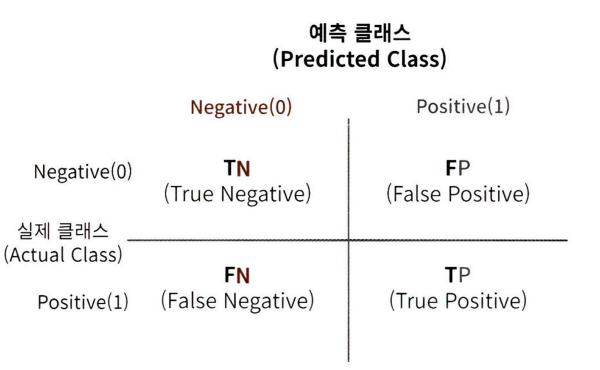

예측 클래스와 실제 클래스의 Positive 결정값(1)과 Negative 결정값(0)의 결합에 따라 결정됨

- TN: 예측값을 Negative 값 0으로 예측했고 실제 값 역시 Negative 값 0
- FP: 예측값을 Positive 값 1로 예측했는데 실제 값은 Negative 값 0
- FN: 예측값을 Negative 값 0으로 예측했는데 실제 값은 Positive 값 1
- TP: 예측값을 Positvie 값 1로 예측했고 실제 값 역시 Positive 값 1



In [6]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

- TN(True Negative)[0,0]: 405
- FP(False Positive)[0,1]: 0
- FN(False Negative)[1,0]:45
- TP(True Positive)[1,1]: 0


> - target==7인지 아닌지에 따라 클래스 값을 T/F 이진분류로 변경한 데이터 세트를 사용함 -> 무조건 Negative로 예측하는 Classifier
- 테스트 데이터 세트의 클래스 값 분포는 0이 405건, 1이 45건

> 결과 
- TN: 전체 450건 데이터 중 무조건 Negative 0으로 예측해서 True가 된 결과 405건
- FP: Positive 1로 예측한 건수가 없으므로 0건
- FN: Positive 1인 건수 45건을 Negative로 예측해서 False가 된 결과 45건
- TP: Positive 1로 예측한 건수가 없으므로 0건



- 정확도=(예측 결과와 실제 값이 동일한 건수)/(전체 데이터 수)=(TN+TP)/(TN+FP+FN+TP)

- 불균형한 이진 분류 데이터 세트에서는 Positive 데이터 건수가 매우 작음 

-> 데이터에 기반한 ML 알고리즘은 Positive보다 Negative로 예측 정확도가 높아지는 경향 

- Negative에 대한 예측 정확도만으로도 분류의 정확도가 매우 높게 나타나는 수치적인 판단 오류 

## 2. 정밀도와 재현율
- Positive 데이터 세트의 예측과 성능에 좀 더 초점을 맞춘 평가 지표

- 정밀도=TP/(FP+TP)
  - 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
- 재현율=TP/(FN+TP)
  - 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율


[재현율 VS 정밀도]
- 재현율
  - 재현율이 더 중요한 지표인 경우: Positive 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
  - 재현율은 FN 낮추는 데 초점
  - recall_score()
- 정밀도
  - 정밀도가 상대적으로 더 중요한 지표인 경우: Negative 데이터 예측을 Positive으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
  - 정밀도는 FP를 낮추는 데 초점 
  - precision_score()

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

 #get_clf_eval(): confusion matrix, accuracy, precision, recall 등의 평가를 한꺼번에 호출하는 함수
def get_clf_eval(y_test, pred):
  confusion=confusion_matrix(y_test, pred)
  accuracy=accuracy_score(y_test, pred)
  precision=precision_score(y_test, pred)
  recall=recall_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  print('정확도:{0:.4f}, 정밀도:{1:.4f}'.format(accuracy, precision, recall))


In [8]:
# 로지스틱 회귀 기반으로 타이타닉 생존자 예측 후 get_clf_eval() 수행
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df=pd.read_csv('train.csv')
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived', axis=1)
X_titanic_df=transform_features(X_titanic_df)

X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)
lr_clf=LogisticRegression()
lr_clf.fit(X_train, y_train)
pred=lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


> 정밀도에 비해 재현율이 낮게 나옴. 재현율, 정밀도를 좀 더 강화할 방법?



### 정밀도/재현율 트레이드오프
- 정밀도/재현율 트레이드 오프: 정밀도와 재현율은 상호 보완적인 평가 지표이기에 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지게 됨 
- 사이킷런의 분류 알고리즘은 예측 데이터가 특정 레이블에 속하는지를 계산하기 위해 먼저 개별 레이블별로 결정 확률을 구함
- 예측 확률이 큰 레이블값으로 예측
- 이진 분류에서는 임곗값을 0.5로, 이 기준 값보다 확률이 크면 Positive, 작으면 Negative로 결정


In [9]:
pred_proba=lr_clf.predict_proba(X_test)
pred=lr_clf.predict(X_test)
print('pred_proba()결과 Shape:{0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

#예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result=np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측\n', pred_proba_result[:3])

pred_proba()결과 Shape:(179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46197474 0.53802526]
 [0.87872398 0.12127602]
 [0.87719492 0.12280508]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측
 [[0.46197474 0.53802526 1.        ]
 [0.87872398 0.12127602 0.        ]
 [0.87719492 0.12280508 0.        ]]


In [10]:
# 사이킷런의 정밀도/재현율 트레이드오프 방식 이해
from sklearn.preprocessing import Binarizer
X=[[1,-1,2],
   [2,0,0],
   [0,1.1,1.2]]
# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer=Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


Binarizer의 threshold값이 1.1보다 작으면 0, 크면 1로 반환

In [11]:
from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값. 분류 결정 임곗값임
custom_threshold=0.5

#predict_proba() 변환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1=pred_proba[:,1].reshape(-1,1)

binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict=binarizer.transform(pred_proba_1)

get_clf_eval(y_test,custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742


In [12]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold=0.4
pred_proba_1=pred_proba[:,1].reshape(-1,1)
binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict=binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도:0.8324, 정밀도:0.7183


 임곗값 0.5-> 0.4
- TP: 47-> 50/ FN: 14->11
- 재현율: 0.770->0.820
- FP: 10->21
- 정밀도: 0.825->0.704
- 정확도:0.866->0.821

: Tradeoff

In [13]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds=[0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  #thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행
  for custom_threshold in thresholds:
    binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
    custom_predict=binarizer.transform(pred_proba_c1)
    print('임곗값:', custom_threshold)
    get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도:0.8324, 정밀도:0.7183
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도:0.8492, 정밀도:0.7656
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도:0.8659, 정밀도:0.8364
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도:0.8771, 정밀도:0.8824


재현율을 향상시키면서 다른 수치를 어느 정도 감소하는 희생을 해야 한다면 임곗값 0.45가 가장 적당해 보임

#### precision_recall_curve() : 타이타닉 예측 모델의 임곗값별 정밀도와 재현율 구현

In [14]:
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1=lr_clf.predict_proba(X_test)[:,1]

#실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds=precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출
thr_index=np.arange(0,thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index],2))

#15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index],3))

반환된 분류 결정 임곗값 배열의 Shape: (165,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값: [0.01 0.09 0.11 0.13 0.15 0.23 0.35 0.5  0.63 0.75 0.89]
샘플 임계값별 정밀도: [0.341 0.372 0.415 0.448 0.505 0.585 0.688 0.774 0.913 0.935 0.938]
샘플 임계값별 재현율: [1.    1.    0.967 0.918 0.902 0.902 0.869 0.787 0.689 0.475 0.246]


임곗값이 증가할수록 정밀도 값은 동시에 높아지거나 재현율 값은 낮아짐

- precision_recall_curve(): 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태의 그래프로 시각화


In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [16]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
  #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
  precisions, recalls, thresholds=precision_recall_curve(y_test, pred_proba_1)

  #X축: threshold, Y축: 정밀도, 재현율 값으로 plot(정밀도는 점선)
  plt.figure(figsize=(8,6))
  threshold_boundary=thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  #threshold값 X축의 Scale을 0.1 단위로 변경
  start, end=plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1),2))
  plt.xlabel('Threshold value')
  plt.ylabel('Precision and Recall value')
  plt.legend()
  plt.grid()
  plt.show()

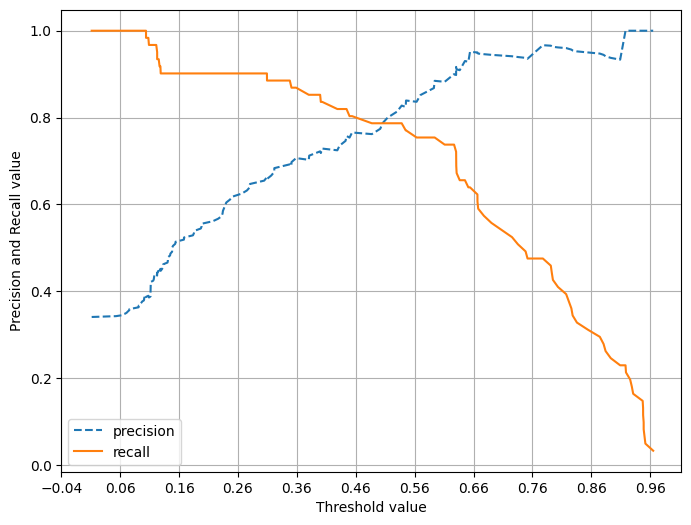

In [17]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

임곗값이 낮을수록 많은수의 양성 예측으로 인해 재현율 값이 극도로 높아지고 정밀도 값이 극도로 낮아짐.


## F1 스코어: 정밀도와 재현율을 결합한 지표
- 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값


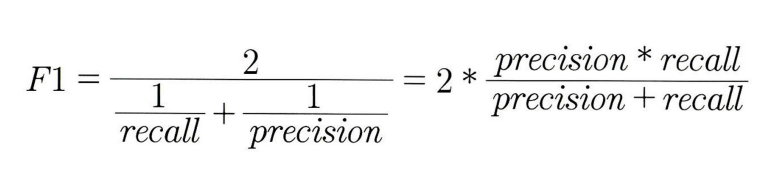

In [18]:
from sklearn.metrics import f1_score
f1=f1_score(y_test, pred)
print('F1 스코어:{0:.4f}'.format(f1))

F1 스코어:0.7805


In [19]:
# 타이타닉 생존자 예측에서 임곗값을 변화시키면서 F1 스코어를 포함한 평가 지표를 구해보자.
def get_clf_eval(y_test, pred):
  confusion=confusion_matrix(y_test, pred)
  accuracy=accuracy_score(y_test, pred)
  precision=precision_score(y_test, pred)
  recall=recall_score(y_test, pred)

  #F1 스코어 추가
  f1=f1_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  #f1 score print 추가
  print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

In [20]:
thresholds=[0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba=lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도:0.8324, 정밀도:0.7183, 재현율:0.8361, F1:0.7727
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도:0.8492, 정밀도:0.7656, 재현율:0.8033, F1:0.7840
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742, 재현율:0.7869, F1:0.7805
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도:0.8659, 정밀도:0.8364, 재현율:0.7541, F1:0.7931
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도:0.8771, 정밀도:0.8824, 재현율:0.7377, F1:0.8036


F1 스코어는 임곗값이 0.6일 때 가장 좋은 값. 하지만 재현율이 크게 감소하니 주의 필요!


## 5. ROC 곡선과 AUC
- ROC 곡선(Receiver Operation Characteristic Curve):  수신자 판단 곡선. 머신러닝의 이진 분류 모델의 예측 성능 판단하는 중요한 평가 지표
- 민감도(TPR): 실제값 Postive(양성)가 정확히 예측되어야 하는 수준(질병 있는 사람은 질병이 있는 것으로 양성 판정)
- 특이성(TNR): 실제값 Negative(음성)가 정확히 예측되어야 하는 수준(질병 없는 사람은 질병  없는 것으로 음성 판정)

- roc_curve()

In [21]:
from sklearn.metrics import roc_curve

#레이블 값이 1일 때의 에측 확률을 추출
pred_proba_class1=lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds=roc_curve(y_test, pred_proba_class1)
#반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 step으로 추출
#thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index=np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index],2))

#5step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR:', np.round(fprs[thr_index],3))
print('샘플 임곗값별 TPRL', np.round(tprs[thr_index],3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값: [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR: [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPRL [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


> 임곗값이 1에 가까운 값에서 점점 작아지면서 FPR이 점점 커짐/ FPR이 조금씩 커질 때 TPR은 가파르게 커짐

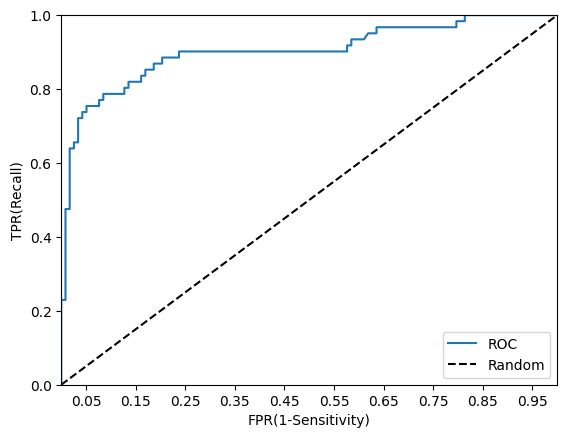

In [22]:
#FPR 변화에 따른 TPR의 변화를 ROC 곡선으로 시각화
def roc_curve_plot(y_test, pred_proba_c1):
  #임곗값에 따른 FPR, TPR 값을 반환받음
  fprs, tprs, thresholds=roc_curve(y_test, pred_proba_c1)
  #ROC 곡선을 그래프 곡선으로 그림
  plt.plot(fprs, tprs, label='ROC')
  #가운데 대각선 직선을 그림
  plt.plot([0,1],[0,1], 'k--', label='Random')

  #FPR X축의 Scale을 0.1 단위로 변경, X,Y축 명 설정
  start, end=plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1),2))
  plt.xlim(0,1)
  plt.ylim(0,1)
  plt.xlabel('FPR(1-Sensitivity)')
  plt.ylabel('TPR(Recall)')
  plt.legend()

roc_curve_plot(y_test, pred_proba[:,1])

- ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는 데 이용
- 분류의 성능 지표로 사용: ROC 곡선 면적에 기반한 AUC 값으로 결정, 1에 가까울수록 좋은 수치 


In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

In [25]:
'''
print(confusion_matrix(y_taregt, preds))
print('정확도:', np.round(accuracy_score(y_target, preds),4))
print('정밀도:', np.round(precision_score(y_target, preds),4))
print('재현율:', np.round(recall_score(y_target, preds),4))
'''

"\nprint(confusion_matrix(y_taregt, preds))\nprint('정확도:', np.round(accuracy_score(y_target, preds),4))\nprint('정밀도:', np.round(precision_score(y_target, preds),4))\nprint('재현율:', np.round(recall_score(y_target, preds),4))\n"

In [26]:
from sklearn.metrics import roc_auc_score
pred = lr_clf.predict(X_test)
roc_score = roc_auc_score(y_test, pred)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8341


In [27]:
#get_clf_eval(): 정확도, 정밀도, 재현율, F1 스코어, ROC AUC 값까지 출력하는 함수
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion=confusion_matrix(y_test, pred)
  accuracy=accuracy_score(y_test, pred)
  precision=precision_score(y_test, pred)
  recall=recall_score(y_test, pred)
  f1=f1_score(y_test, pred)
  # ROC-AUC 추가
  roc_auc=roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))